<a href="https://colab.research.google.com/github/rygo1232/ryan1/blob/main/DP_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install bayesian-optimization


# **new model**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from google.colab import drive
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
tfd = tfp.distributions

# **Data Preparation**

In [23]:

#url = 'https://github.com/rygo1232/ryan1/raw/refs/heads/main/OPR_Data_dp.xlsx'
opr_data.head()

,Date,loss,Internal_fraud,External_fraud,Employ_PWS,Clients_PBP,Disaster,ICT_Failure,Execution_DP
0,1980,36018.753329,1750.451152,724.457873,1654.193170,21567.986642,211.948435,5250.449005,4859.267052
1,1981,29372.554728,1892.549168,1520.499982,646.700805,11387.686902,173.970695,4141.188918,9609.958258
2,1982,38563.417720,2258.135870,2004.194960,1721.763552,15672.845439,104.770430,5244.595006,11557.112464
3,1983,34344.402654,2237.661436,2037.584475,2013.382715,11764.072979,48.245058,6086.596058,10156.859932
4,1984,31823.887478,535.631442,1639.947623,1448.060942,11958.526408,155.857865,5097.720141,10988.143057


from matplotlib import pyplot as plt
_df_0['Date'].plot(kind='hist', bins=20, title='Date')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Internal_fraud'].plot(kind='hist', bins=20, title='Internal_fraud')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['External_fraud'].plot(kind='hist', bins=20, title='External_fraud')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Date', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='loss', y='Internal_fraud', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Internal_fraud', y='External_fraud', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='External_fraud', y='Employ_PWS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Internal_fraud']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Internal_fraud')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['External_fraud']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('External_fraud')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Employ_PWS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Employ_PWS')

from matplotlib import pyplot as plt
_df_12['Date'].plot(kind='line', figsize=(8, 4), title='Date')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Internal_fraud'].plot(kind='line', figsize=(8, 4), title='Internal_fraud')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['External_fraud'].plot(kind='line', figsize=(8, 4), title='External_fraud')
plt.gca().spines[['top', 'right']].set_visible(False)

# **density and histogram**

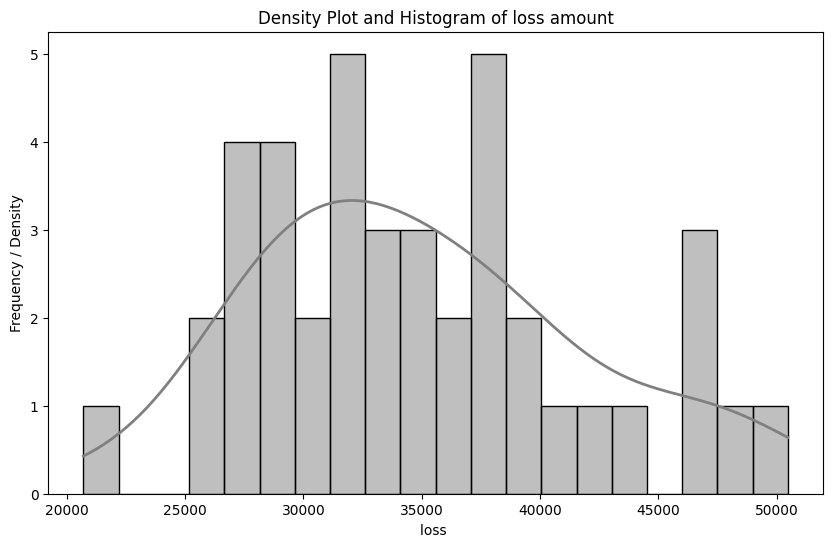

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot density and histogram for 'Amount_claimed'
plt.figure(figsize=(10, 6))
sns.histplot(
    opr_data['loss'],  # Use the specified column
    bins=20,
    kde=True,
    color='gray',
    # The 'linewidth' parameter should be in 'line_kws' for kde plot
    line_kws={'linewidth': 2},
    edgecolor='black'  # Adds black edges to bars for better visibility
)

plt.title('Density Plot and Histogram of loss amount')
plt.xlabel('loss ')
plt.ylabel('Frequency / Density')
plt.show()

## **BOXPLOT**

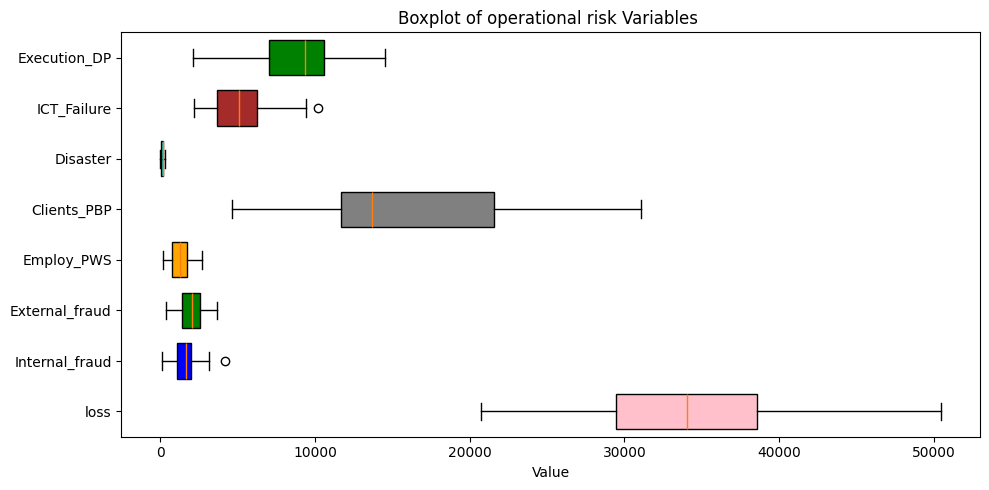

In [56]:
import matplotlib.pyplot as plt

# Remove 'loss_category' from the columns if it exists
columns_to_plot = [col for col in opr_data.columns if col != 'loss_category']

# Set a larger figure size for better visibility
plt.figure(figsize=(10, 5))

# Get data for each variable
data = [opr_data[col].dropna() for col in columns_to_plot]

# Define colors for each variable
colors = ['pink', 'blue', 'green', 'orange', 'gray', 'cyan', 'brown', 'green']
colors = colors[:len(data)]  # Ensure the number of colors matches the data

# Plot each box with specified colors
ax = plt.gca()
for i, (dat, color) in enumerate(zip(data, colors)):
    bp = ax.boxplot(dat, vert=False, positions=[i+1], patch_artist=True, widths=0.7)
    for patch in bp['boxes']:
        patch.set_facecolor(color)

# Set y-ticks to variable names
ax.set_yticks(range(1, len(columns_to_plot) + 1))
ax.set_yticklabels(columns_to_plot)

# Improve layout and size
plt.xlabel('Value')
plt.title('Boxplot of operational risk Variables ')
plt.tight_layout()

plt.show()

# **SKEWNESS**

<ipython-input-57-91aff6934c19>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=skewness.index, y=skewness.values, palette=bar_colors)


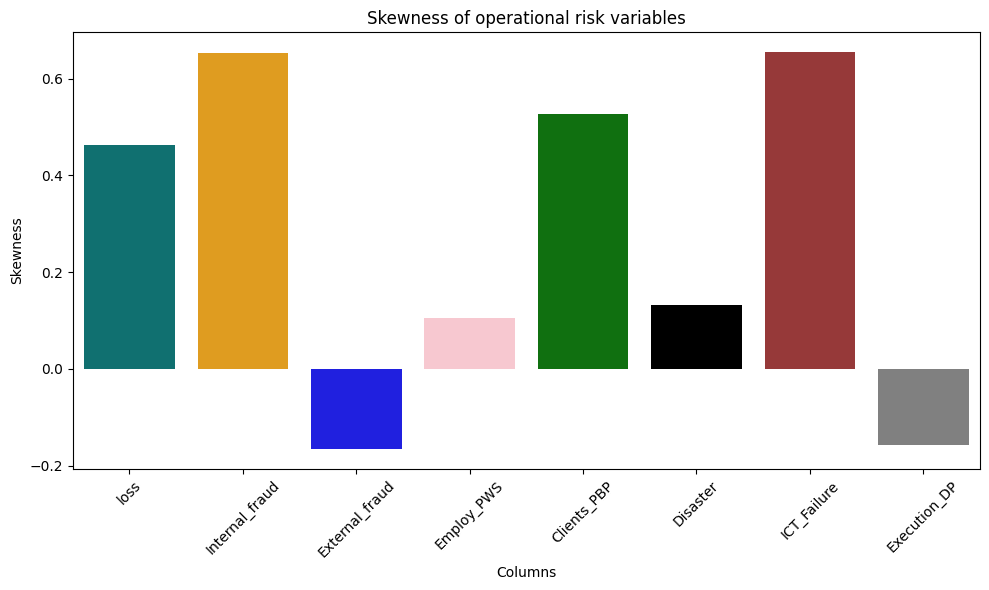

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colors based on the previous description
colors = {
    'Execution_DP': 'gray',
    'ICT_Failure': 'brown',
    'External_fraud': 'blue',
    'Employ_PWS': 'pink',
    'Clients_PBP': 'green',
    'Disaster': 'black',
    'Internal_fraud': 'orange',
    'loss': 'teal'
}

# Calculate skewness only for numerical columns
numerical_cols = opr_data.select_dtypes(include=np.number).columns  # Select only numerical columns
skewness = opr_data[numerical_cols].skew()

# Get colors for the skewness columns, default to a general color if not specified
bar_colors = [colors.get(col, 'grey') for col in skewness.index]

# Create the barplot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=skewness.index, y=skewness.values, palette=bar_colors)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness of operational risk variables')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# **summary statistics**

In [74]:
# Generate transposed summary statistics for the opr_data DataFrame
summary_stats = opr_data.describe().T
print(summary_stats)

                count          mean          std           min           25%  \
loss             41.0  34856.566804  6930.725871  20702.150593  29445.951989   
Internal_fraud   41.0   1616.272387   796.800432    100.000000   1036.749475   
External_fraud   41.0   2049.428446   869.720842    368.614258   1401.210771   
Employ_PWS       41.0   1265.901955   656.351516    132.767851    725.715327   
Clients_PBP      41.0  15668.048635  6387.115520   4601.077389  11648.759648   
Disaster         41.0    126.860026    73.939909      0.000000     61.345083   
ICT_Failure      41.0   5332.128420  2062.895851   2194.789456   3674.198165   
Execution_DP     41.0   8797.926935  2843.961533   2100.930232   7031.960483   

                         50%           75%           max  
loss            34061.532182  38563.417720  50473.459584  
Internal_fraud   1651.521013   1980.382133   4196.912043  
External_fraud   2059.275824   2574.033805   3648.598340  
Employ_PWS       1265.636877   1693.902350 

In [35]:
# Load and prepare data
def load_and_prepare_data(file_path):
    # Load data
    opr_data = pd.read_excel(file_path)

    # Create a copy of original data for reference
    original_data = opr_data.copy()

    # Exploratory Data Analysis
    print("Data Overview:")
    print(f"Shape: {opr_data.shape}")
    print("\nData Types:")
    print(opr_data.dtypes)
    print("\nMissing Values:")
    print(opr_data.isnull().sum())

    # Set 'Date' as index if it's not already
    if 'Date' in opr_data.columns:
        opr_data.set_index('Date', inplace=True)

    # Handle missing values with more sophisticated approach
    for column in opr_data.columns:
        if opr_data[column].isnull().sum() > 0:
            # For numeric columns, use median instead of forward fill
            if pd.api.types.is_numeric_dtype(opr_data[column]):
                opr_data[column].fillna(opr_data[column].median(), inplace=True)
            else:
                opr_data[column].fillna(opr_data[column].mode()[0], inplace=True)

    # Feature Engineering: Create ratios and percentages
    opr_data['Internal_External_Ratio'] = opr_data['Internal_fraud'] / (opr_data['External_fraud'] + 1)  # Add 1 to avoid division by zero
    opr_data['Fraud_Total'] = opr_data['Internal_fraud'] + opr_data['External_fraud']
    opr_data['Fraud_Percent'] = opr_data['Fraud_Total'] / (opr_data['loss'] + 1) * 100

    # Create lag features for time series analysis
    for col in ['loss', 'Internal_fraud', 'External_fraud']:
        opr_data[f'{col}_prev_year'] = opr_data[col].shift(1)

    # Drop rows with NaN values created by lag features
    opr_data.dropna(inplace=True)

    # Outlier detection using IQR method
    numeric_cols = opr_data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        Q1 = opr_data[col].quantile(0.25)
        Q3 = opr_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Instead of removing outliers, cap them (Winsorization)
        opr_data[col] = np.where(opr_data[col] > upper_bound, upper_bound,
                              np.where(opr_data[col] < lower_bound, lower_bound, opr_data[col]))

    # Encode categorical features (if any)
    categorical_cols = opr_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        opr_data[col] = le.fit_transform(opr_data[col])
        label_encoders[col] = le

    # Feature selection
    if len(opr_data.columns) > 5:  # Only if we have enough features
        X_select = opr_data.drop('loss', axis=1)
        y_select = opr_data['loss']

        # Select top k features
        k = min(5, len(X_select.columns))  # Select top 5 or all if less than 5
        selector = SelectKBest(f_regression, k=k)
        selector.fit(X_select, y_select)

        # Get selected feature names
        selected_features = X_select.columns[selector.get_support()]
        print("\nTop features selected:")
        print(selected_features)

        # We'll keep all features but note the important ones

    # Scale features - using RobustScaler for financial data which may have outliers
    scaler = RobustScaler()  # More robust to outliers than StandardScaler
    opr_data[numeric_cols] = scaler.fit_transform(opr_data[numeric_cols])

    # Prepare features and target
    X = opr_data.drop('loss', axis=1)
    y = opr_data['loss']

    # Shuffle and split - using time-aware split for time series
    # Take the last 20% as test set instead of random
    train_size = int(0.8 * len(opr_data))
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    # Return processed data and metadata
    return X_train, X_test, y_train, y_test, scaler, label_encoders, original_data, opr_data
print("Data Preparation Complete!")
print("---------------------------")
print("Data Overview:")
print(f"Shape: {opr_data.shape}")
print("\nData Types:")
print(opr_data.dtypes)
print("\nMissing Values:")
print(opr_data.isnull().sum())

Data Preparation Complete!
---------------------------
Data Overview:
Shape: (41, 9)

Data Types:
loss               float64
Internal_fraud     float64
External_fraud     float64
Employ_PWS         float64
Clients_PBP        float64
Disaster           float64
ICT_Failure        float64
Execution_DP       float64
loss_category     category
dtype: object

Missing Values:
loss              0
Internal_fraud    0
External_fraud    0
Employ_PWS        0
Clients_PBP       0
Disaster          0
ICT_Failure       0
Execution_DP      0
loss_category     0
dtype: int64


In [87]:
import pandas as pd

# Calculate the correlation matrix for numerical columns
correlation_matrix = original_data.corr()

# To display only the relevant parts, you might select specific columns if desired
# For example:
# correlation_matrix = correlation_matrix[['loss', 'OtherFeature1', 'OtherFeature2']]

In [88]:
# List of feature names (excluding target 'loss' if needed)
feature_names = [col for col in original_data.columns if col != 'loss']

# Calculate correlation of each feature with 'loss'
correlation_with_loss = original_data[feature_names].corrwith(original_data['loss'])

# Convert to lists for plotting
correlation_with_loss_values = correlation_with_loss.values

<ipython-input-97-d9712fe7d913>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=correlation_with_loss_values, palette=custom_colors)


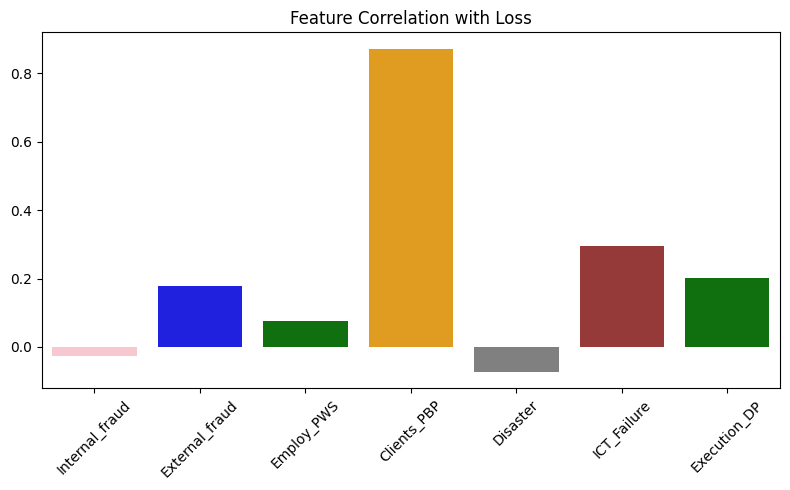

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'original_data' is your DataFrame

# 1. Get feature names excluding 'loss' and 'Date'
feature_names = [col for col in original_data.columns if col not in ['loss', 'Date']]

# 2. Compute correlation with 'loss'
correlation_with_loss = original_data[feature_names].corrwith(original_data['loss'])
correlation_with_loss_values = correlation_with_loss.values

# 3. Define your custom colors for each feature
# Make sure the number of colors matches the number of features
custom_colors =  ['pink', 'blue', 'green', 'orange', 'gray', 'brown', 'green']
# Example: if you have 7 features, this list should have 7 color strings.

# 4. Plot with your custom colors
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_names, y=correlation_with_loss_values, palette=custom_colors)
plt.title('Feature Correlation with Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

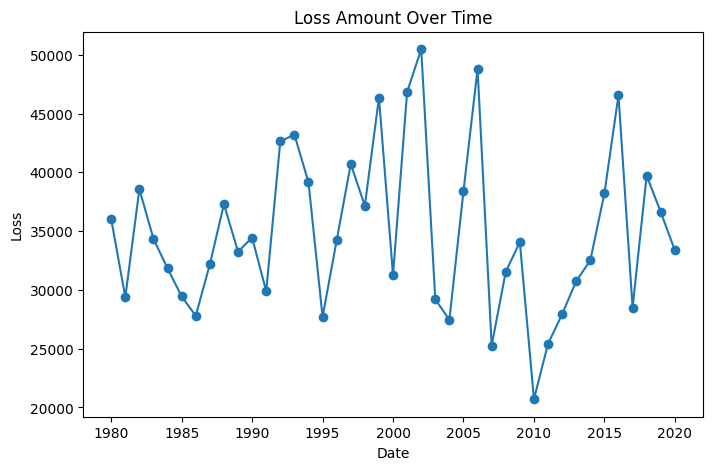

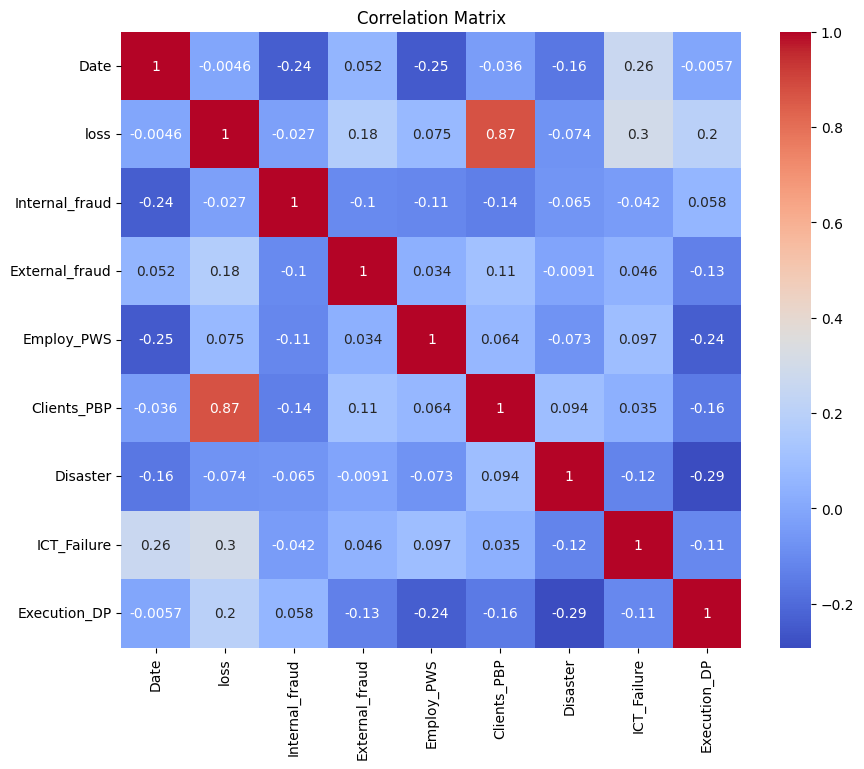

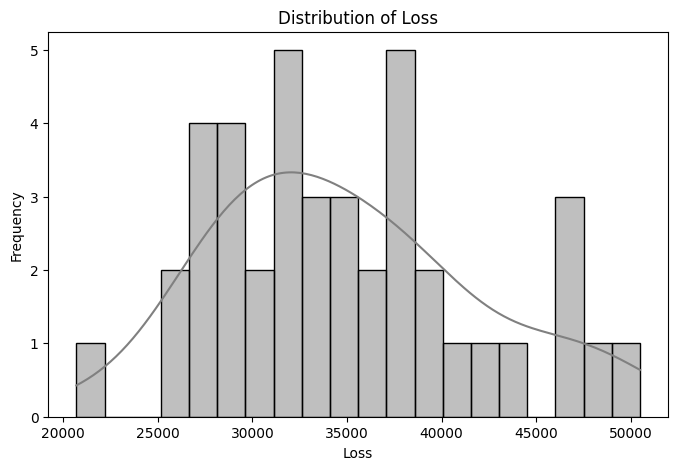

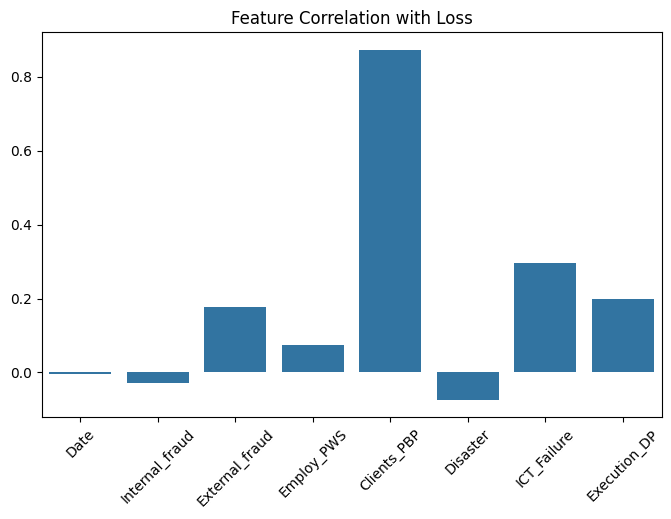

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'original_data' is your DataFrame

# 1. Compute correlation matrix
correlation_matrix = original_data.corr()

# 2. Get feature names and correlation with 'loss'
feature_names = [col for col in original_data.columns if col != 'loss']
correlation_with_loss = original_data[feature_names].corrwith(original_data['loss'])
correlation_with_loss_values = correlation_with_loss.values

# 3. Plotly your visualization function as before
def visualize_data_separately():
    # Loss over time
    plt.figure(figsize=(8, 5))
    plt.plot(original_data['Date'], original_data['loss'], marker='o')
    plt.title('Loss Amount Over Time')
    plt.xlabel('Date')
    plt.ylabel('Loss')
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Distribution of Loss
    plt.figure(figsize=(8, 5))
    sns.histplot(original_data['loss'], bins=20, kde=True, color='gray')
    plt.title('Distribution of Loss')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.show()

    # Feature correlation with Loss
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature_names, y=correlation_with_loss_values)
    plt.title('Feature Correlation with Loss')
    plt.xticks(rotation=45)
    plt.show()

#Call the function
visualize_data_separately()

Data Overview:
Shape: (41, 9)

Data Types:
Date                int64
loss              float64
Internal_fraud    float64
External_fraud    float64
Employ_PWS        float64
Clients_PBP       float64
Disaster          float64
ICT_Failure       float64
Execution_DP      float64
dtype: object

Missing Values:
Date              0
loss              0
Internal_fraud    0
External_fraud    0
Employ_PWS        0
Clients_PBP       0
Disaster          0
ICT_Failure       0
Execution_DP      0
dtype: int64

Top features selected:
Index(['Clients_PBP', 'ICT_Failure', 'Fraud_Percent',
       'Internal_fraud_prev_year', 'External_fraud_prev_year'],
      dtype='object')


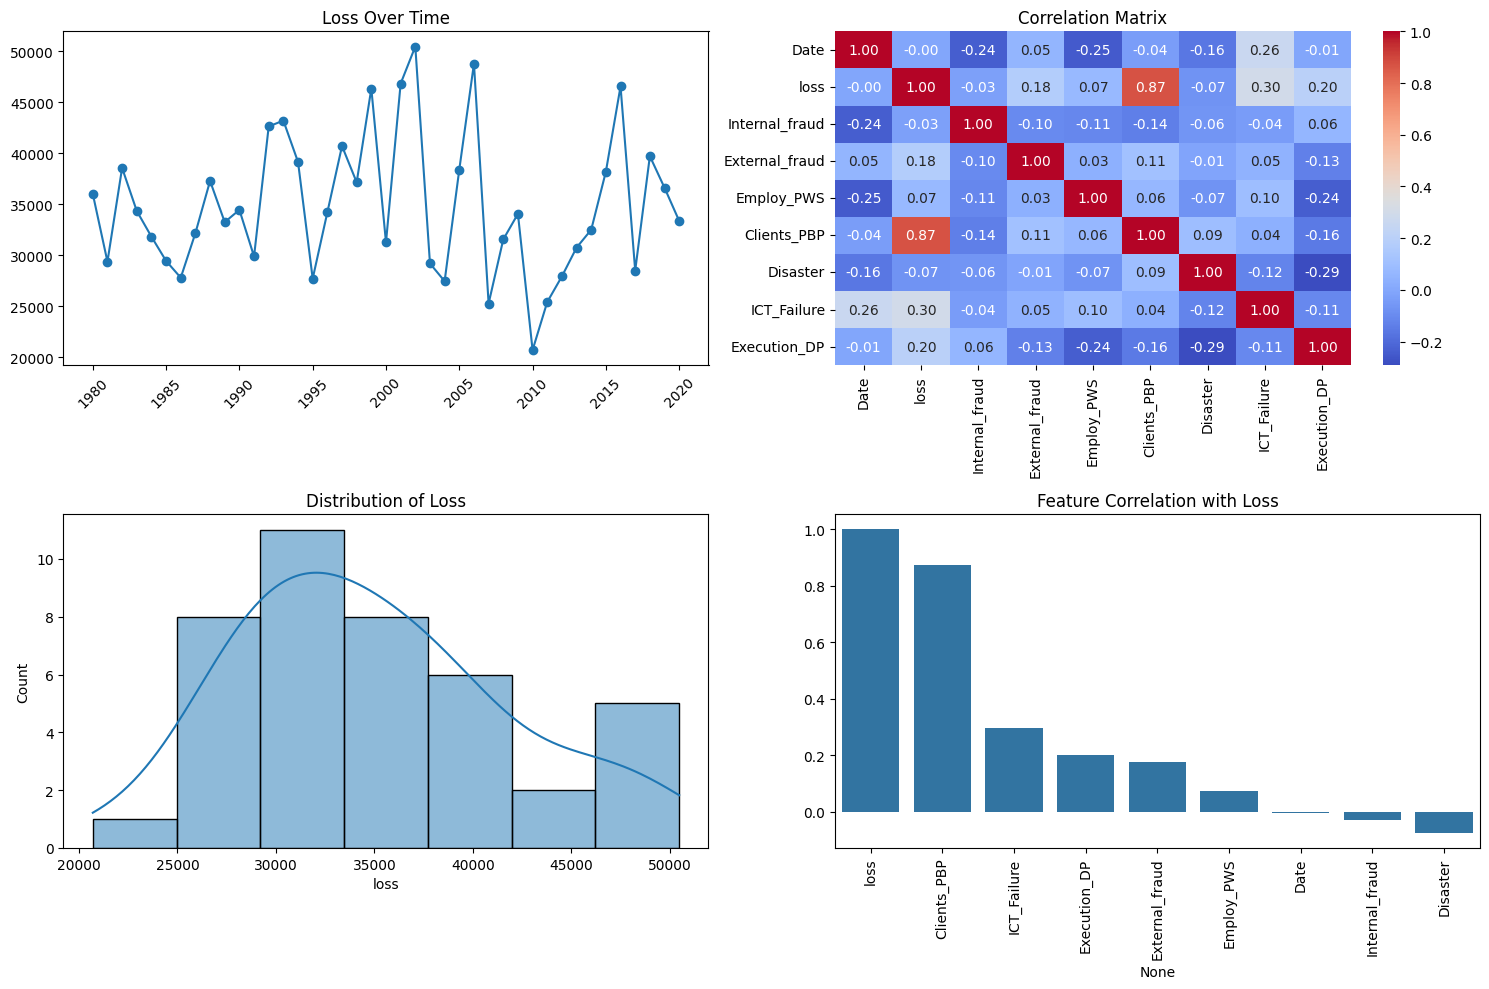


Shapes after conversion:
X_train shape: (32, 13), y_train shape: (32, 1)
X_test shape: (8, 13), y_test shape: (8, 1)


In [85]:

# Visualization function for exploratory analysis
def visualize_data(original_data, processed_data):
    plt.figure(figsize=(15, 10))


    # Plot loss over time
    plt.subplot(2, 2, 1)
    plt.plot(original_data['Date'], original_data['loss'], marker='o')
    plt.title('Loss Over Time')
    plt.xticks(rotation=45)

    # Correlation heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(original_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')

    # Distribution of loss
    plt.subplot(2, 2, 3)
    sns.histplot(original_data['loss'], kde=True)
    plt.title('Distribution of Loss')

    # Feature importance (using correlation with target)
    plt.subplot(2, 2, 4)
    corr_with_target = original_data.corr()['loss'].sort_values(ascending=False)
    sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
    plt.title('Feature Correlation with Loss')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

# Load your data
file_path = 'https://github.com/rygo1232/ryan1/raw/refs/heads/main/OPR_Data_dp.xlsx'
X_train, X_test, y_train, y_test, scaler, label_encoders, original_data, processed_data = load_and_prepare_data(file_path)

# Visualize the data
visualize_data(original_data, processed_data)

# Print the shapes to verify
print("\nShapes after conversion:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# **ANN Model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.2095 - mae: 0.6999 - val_loss: 1.9165 - val_mae: 0.4931
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.1184 - mae: 0.6475 - val_loss: 1.8961 - val_mae: 0.4924
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.0302 - mae: 0.6171 - val_loss: 1.8752 - val_mae: 0.4904
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 2.0367 - mae: 0.6292 - val_loss: 1.8518 - val_mae: 0.4862
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 2.0359 - mae: 0.6124 - val_loss: 1.8286 - val_mae: 0.4819
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.9361 - mae: 0.5633 - val_loss: 1.8054 - val_mae: 0.4759
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.9046 - mae: 0.5482 - val_loss: 1.7832 - val_mae: 0.4700
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.8521 - mae: 0.5337 - val_loss: 1.7585 - val_mae: 0.4631
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.8427 - m

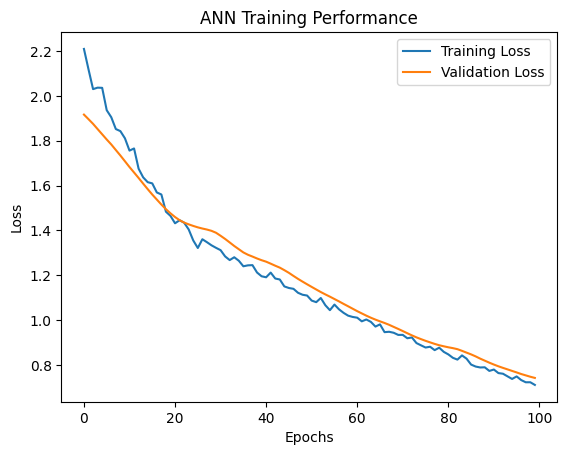


ANN Evaluation:
MSE: 0.0592
MAE: 0.2051
R²: 0.8249


In [ ]:

def build_train_ann(X_train, y_train, X_test, y_test):
    # Model architecture with L2 Regularization
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
        Dropout(0.3),  # Dropout layer to reduce overfitting
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Optional L2 Regularization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Optional L2 Regularization
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=100, batch_size=32,
                        callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ANN Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nANN Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history

# Run the ANN
ann_model, ann_history = build_train_ann(X_train, y_train, X_test, y_test)

# **LSTM Model**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6153 - val_loss: 0.3822 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6239 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.6036 - val_loss: 0.3797 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.5975 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.5717 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.5769 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5451 - val_loss: 0.3808 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.5474 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.5446 - val_loss: 0.3852 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━

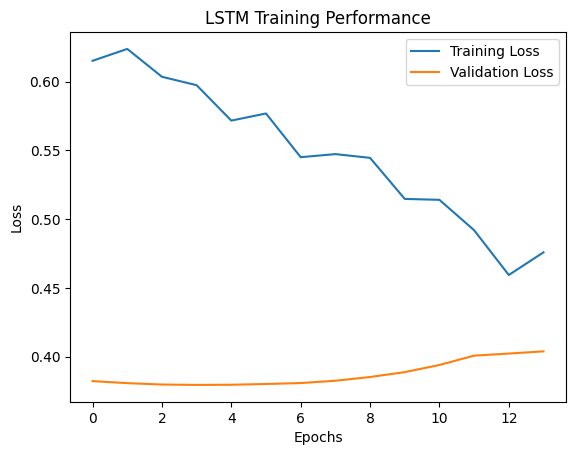


LSTM Evaluation:
MSE: 0.3794
MAE: 0.4845
R²: -0.1217


In [ ]:

def build_train_lstm(X_train, y_train, X_test, y_test):
    # Reshape data for LSTM
    X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model architecture
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.4))  # Dropout layer to prevent overfitting
    model.add(LSTM(32, activation='tanh'))  # Second LSTM layer
    model.add(Dropout(0.4))  # Another Dropout layer
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)

    # Fit the model
    history = model.fit(X_train_seq, y_train,
                        validation_data=(X_test_seq, y_test),
                        epochs=100,
                        batch_size=32,  # Adjust batch size as needed
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    # Evaluate
    y_pred = model.predict(X_test_seq)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nLSTM Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

    return model, history

# Run the LSTM
lstm_model, lstm_history = build_train_lstm(X_train, y_train, X_test, y_test)



# Autoencoder

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7987 - val_loss: 0.9305
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.7970 - val_loss: 0.9288
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.7954 - val_loss: 0.9270
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.7938 - val_loss: 0.9250
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.7921 - val_loss: 0.9229
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.7903 - val_loss: 0.9206
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.7885 - val_loss: 0.9182
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.7865 - val_loss: 0.9157
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.7844 - val_loss: 0.9130
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.7821 - val_loss: 0.9102
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.7796 - val_loss: 0.9072
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.7769 - v

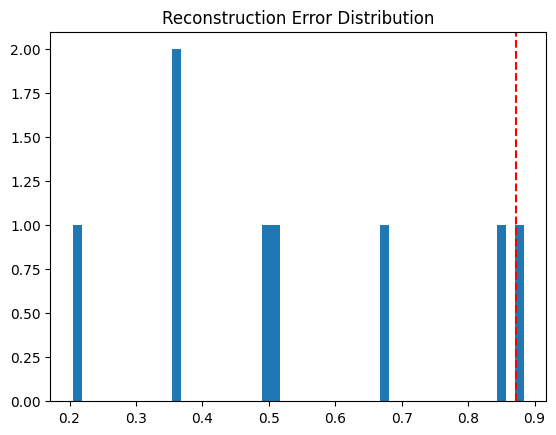


Anomalies detected: 1/8


In [ ]:
def build_train_autoencoder(X_train, X_test):
    # Model architecture
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    # Train
    history = model.fit(X_train, X_train,
                       epochs=100, batch_size=32,
                       validation_data=(X_test, X_test),
                       verbose=1)

    # Detect anomalies
    X_test_pred = model.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    anomalies = reconstruction_error > threshold

    # Plot results
    plt.hist(reconstruction_error, bins=50)
    plt.axvline(threshold, color='r', linestyle='--')
    plt.title('Reconstruction Error Distribution')
    plt.show()

    print(f"\nAnomalies detected: {sum(anomalies)}/{len(anomalies)}")
    return model, reconstruction_error

# Run the autoencoder
autoencoder, reconstruction_error = build_train_autoencoder(X_train, X_test)

# **Bayesian Neural Network**

In [ ]:
def build_train_bnn(X_train, y_train, X_test, y_test):
    # Define BNN using DenseFlipout for uncertainty estimation
    # The inputs variable was not defined, it should be the Input layer
    inputs = Input(shape=(X_train.shape[1],))
    x = tfp.layers.DenseFlipout(64, activation='relu')(inputs)
    x = tfp.layers.DenseFlipout(32, activation='relu')(x)
    outputs = tfp.layers.DenseFlipout(1)(x)

    # Compile model with MSE loss and Adam optimizer
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    # Train with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Bayesian prediction with uncertainty (Monte Carlo sampling)
    n_samples = 100
    y_preds = np.stack([model(X_test, training=True).numpy().squeeze() for _ in range(n_samples)])
    y_pred_mean = y_preds.mean(axis=0)
    y_pred_std = y_preds.std(axis=0)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred_mean)
    mae = mean_absolute_error(y_test, y_pred_mean)
    r2 = r2_score(y_test, y_pred_mean)

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training History')

    plt.subplot(1, 2, 2)
    plt.errorbar(y_test, y_pred_mean, yerr=2*y_pred_std, fmt='o', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('True')
    plt.ylabel('Predicted ± 2σ')
    plt.title('Predictions with Uncertainty')
    plt.tight_layout()
    plt.show()

    print(f"\nBNN Evaluation (using {n_samples} samples):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Mean uncertainty: {y_pred_std.mean():.4f}")

    return model, history

# **feedforward neural network (FFNN)**

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

def build_train_ffnn(X_train, y_train, X_test, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nNN Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return model, history

# Run the feedforward neural network
ffnn_model, ffnn_history = build_train_ffnn(X_train, y_train, X_test, y_test)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6995 - mae: 0.6412 - val_loss: 0.4475 - val_mae: 0.5539
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.6459 - mae: 0.6189 - val_loss: 0.4159 - val_mae: 0.5360
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.5965 - mae: 0.5969 - val_loss: 0.3879 - val_mae: 0.5188
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.5514 - mae: 0.5756 - val_loss: 0.3644 - val_mae: 0.5032
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.5104 - mae: 0.5550 - val_loss: 0.3441 - val_mae: 0.4888
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4737 - mae: 0.5373 - val_loss: 0.3265 - val_mae: 0.4751
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.4401 - mae: 0.5219 - val_loss: 0.3114 - val_mae: 0.4613
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4092 - mae: 0.5070 - val_loss: 0.2975 - val_mae: 0.4491
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3798 - m

# **Combined Model**

In [ ]:
def compare_models(models_dict, X_test, y_test):
    results = []

    for name, model in models_dict.items():
        if 'lstm' in name.lower():
            X_test_ = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
        else:
            X_test_ = X_test

        y_pred = model.predict(X_test_)

        # Check if the model is an autoencoder
        if name == 'Autoencoder':
            # For autoencoders, compare the reconstructed input with the original input
            mse = mean_squared_error(X_test_, y_pred)  # Use X_test_ for comparison
            mae = mean_absolute_error(X_test_, y_pred)  # Use X_test_ for comparison
            r2 = r2_score(X_test_, y_pred)  # Use X_test_ for comparison
        else:
            # For other models, use y_test for comparison
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

        # Append the model's results to the results list
        results.append({
            'Model': name,
            'MSE': mse,
            'MAE': mae,
            'R²': r2
        })

    # Return a DataFrame containing the results for all models
    return pd.DataFrame(results)

# Step 2: Create a dictionary of your trained models
# Moved this part outside the function definition
models = {
    'ANN': ann_model,
    'LSTM': lstm_model,
    'Autoencoder': autoencoder,  # Use the autoencoder variable
    'FFNN': ffnn_model
}

# Now, you can use the 'models' dictionary to compare performance
results_df = compare_models(models, X_test, y_test)
print("\nModel Comparison:")
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Model Comparison:
         Model       MSE       MAE        R²
0          ANN  0.059217  0.205077  0.824940
1         LSTM  0.379429  0.484490 -0.121691
2  Autoencoder  0.542690  0.581166 -0.004309
3         FFNN  0.105761  0.227451  0.687343
